### 언론사별 크롤링
- 한겨레, 경향, 프레시안 카테고리(사회/경제/정치/IT)별 크롤링 코드, 몽고db에 업데이트 코드작업

In [1]:
from PIL import Image as pil
import pandas as pd
import numpy as np
import scrapy
import requests
from scrapy.http import TextResponse

#####   한겨레 
- scrapy 사용

In [ ]:
!scrapy startproject hani 

In [ ]:
%%writefile hani/hani/items.py
# Define here the models for your scraped items
#
# See documentation in:
# https://docs.scrapy.org/en/latest/topics/items.html

import scrapy


class HaniItem(scrapy.Item):
    #ID = scrapy.Field()
    press_agency = scrapy.Field()
    category = scrapy.Field()
    link = scrapy.Field()
    title = scrapy.Field()
    content = scrapy.Field()
    p_date = scrapy.Field()
    img = scrapy.Field()
    
#     def to_dict(self):
#         return { "press_agency": press_agency,  "category": category, "link": link, 
#                  "title": title, "content": content, "p_date": p_date, "img": img }

In [ ]:
def get_articles(category, h_list):
    url= "http://m.hani.co.kr/arti/{}/{}_general/list{}.html".format(category,category, h_list)
    req = requests.get(url)
    response = TextResponse(req.url, body=req.text, encoding='utf-8')
    links = response.xpath('/html/body/div/main/section[2]/ul/li/article/div[1]/h4/a/@href').extract()
    links = [response.urljoin(link) for link in links]
    
    
    
    
    datas = []
    for link in links:
        req = requests.get(link)
        response = TextResponse(req.url, body=req.text, encoding='utf-8')
        try:
            press_agency = response.xpath('/html/body/div[1]/main/div/div/div/section/article/div[4]/div[1]/a/text()')[0].extract()
            press_agency = " ".join(press_agency.split("@")[1].split('.')[0])
        except:
            press_agency = 'hani'
        if not press_agency == 'hani':
            press_agency = 'hani'
        #category = response.xpath('/html/body/div[1]/header/div/div[1]/div[2]/a/text()')[0].extract()
        try:
            title = response.xpath('/html/body/div[1]/main/div/div/div/section/article/div[1]/h1/text()')[0].extract()
        except:
            title = response.xpath('//*[@id="article_view_headline"]/h4/span/span/span/text()').extract()
        p_date = response.xpath('/html/body/div[1]/main/div/div/div/section/article/div[3]/div[1]/text()[1]')[0].extract()
        p_date = " ".join(p_date.replace("등록","").split()[0]).strip()
        content = response.xpath('/html/body/div[1]/main/div/div/div/section/article/div[4]/div[1]/text()').extract()
        content = " ".join(content).replace("\n","").replace("\t","").replace("\r","")
        datas.append({
            "ID" : 'itsin',
            "press_agency" : press_agency,
            "category": category,
            "title": title,
            "p_date": p_date,
            "content": content,
            "link" : link,
        })
        
    return pd.DataFrame(datas)
    

In [ ]:
%%writefile hani.sh
cd hani
scrapy crawl Hani -o hanis.csv

In [ ]:
#카테고리 지정하여 사용
categories = {
      "science" : '과학', 
#     "economy" : '경제',
#    "society" : '사회',
#"culture" : '문화',
      
}

In [9]:
hani_df_s = pd.read_csv('datas/hani_df_s.csv') 
hani_df_s.tail()

ID category                                            content  \
6400  itsin  society   유시민 사람사는세상 노무현재단 이사장은 12일"검찰이 조국 장관 또는 조 장관의 ...   
6401  itsin  society    검찰개혁을 촉구하는 아홉 번째 ‘서초동 촛불집회’가 일주일 만인 12일 서울 서...   
6402  itsin  society    “뜨거운 함성과 함께 출발! 시민의 의지로 출발!”  제9차 검찰개혁 촛불문화제...   
6403  itsin  society  일요일인 13일은 전국이 대체로 맑겠다. 이날 아침 기온은 7~17도로 예보됐다. ...   
6404  itsin  society         미하엘 린덴(71) 독일 샤리테대학 교수는 2003년 ‘외상 후 울분장...   

                                                   link      p_date  \
6400  http://m.hani.co.kr/arti/society/society_gener...  2019-10-12   
6401  http://m.hani.co.kr/arti/society/society_gener...  2019-10-12   
6402  http://m.hani.co.kr/arti/society/society_gener...  2019-10-12   
6403  http://m.hani.co.kr/arti/society/society_gener...  2019-10-12   
6404  http://m.hani.co.kr/arti/society/society_gener...  2019-10-12   

     press_agency                                   title  
6400         hani          유시민 “검찰, 조국 부부 수사 확실한 증거 없을 것”  
6401         hani                        “낡은 시스템 여기서 끊어야”  
6402         hani  [만리재사진첩] 검찰개혁 9차 촛불 “우리는 언제든지 다시 모인다”   
6403         hani         [날씨] 일요일 전국 대체로 맑고 미세먼지 농도 ‘좋음’  
6404         hani            “왜 그들이 불공정하다고 느꼈는지 들여다봐야 한다”

##### 경향신문
- scrapy 사용

In [ ]:
!scrapy startproject khan

In [ ]:
%%writefile khan/khan/items.py
import scrapy

class KhanItem (scrapy.Item):
    
    ID = scrapy.Field()
    title = scrapy.Field()
    p_date = scrapy.Field()
    content = scrapy.Field()
    link = scrapy.Field()
    category = scrapy.Field()
    press_agency = scrapy.Field()   


In [ ]:
%%writefile khan/khan/spiders/spider.py
import scrapy
from khan.items import KhanItem
import re

class Spider(scrapy.Spider):
    name = 'Khan'
    allow_domain = ['biz.khan.co.kr']
    def __init__(self, category='economy', **kwargs):
       
        self.start_urls = ['http://biz.khan.co.kr/khan_art_list.html?category={}'.format(category)]
        super().__init__(**kwargs)
    
    def parse(self,response):
        print(response.url)
        breed_urls = []
        for page in range(1,117):
            breed_urls.append(response.url + "&page={}".format(page))
        for url in breed_urls:
            print(url)            
            yield scrapy.Request(url=url,callback=self.parse_sub_urls)
    
    
    def parse_sub_urls(self,response):
        links = response.xpath('//*[@id="container"]/div/div[1]/div[2]/ul/li/div/strong/a/@href').extract()
        for link in links:
            yield scrapy.Request(link, callback=self.parse_content)
            
    def parse_content(self, response):
        item = KhanItem()
        item['ID'] = 'itsin'
        item['title'] = response.xpath('//div[@id="container"]/div/div[1]/div[2]/h1/text()')[0].extract()
        p_date = response.xpath('//div[@id="container"]/div/div[1]/div[3]/div[2]/div[1]/em[1]/text()')[0].extract() 
        item['p_date'] = "".join(p_date).split()[2] 
        content = response.xpath('//div[@id="container"]/div/div[2]/div[1]/p/text()').extract()
        item['content'] = "".join(content)
        item['category'] = 'economy'
        item['press_agency'] = 'khan'
        yield item

In [ ]:
%%writefile Khan.sh
cd khan 
scrapy crawl Khan -o Khan_e.csv

In [15]:
df=pd.read_csv('Khan/Khan_e.csv')
df.tail()

ID category                                            content link  \
1784  itsin  economy  코스피가 16일 오전 장중 2520선까지 올라섰다.이날 오전 9시34분 현재 유가증...  NaN   
1785  itsin  economy  코로나19사태로 취업 시장이 얼어붙은 가운데 구직자들의 빚도 늘어난 것으로 나타났다...  NaN   
1786  itsin  economy  코로나19사태로 기업들의 신입사원 채용이 크게 줄어든 것으로 나타났다.16일 취업포...  NaN   
1787  itsin  economy  KT는 구현모 대표가 세계이동통신협회(GSMA) 이사회 멤버에 선임됐다고 17일 밝...  NaN   
1788  itsin  economy  코스닥시장에 상장되어 있는 대표 바이오기업 헬릭스미스가 지난달 대규모 유상증자를 위...  NaN   

          p_date press_agency  \
1784  2020.11.16         khan   
1785  2020.11.16         khan   
1786  2020.11.16         khan   
1787  2020.11.17         khan   
1788  2020.11.15         khan   

                                                  title  
1784                             코스피 2년 반만에 장중 2500선 돌파  
1785                   구직자 평균 빚, 지난해보다 758만원 늘어난 3019만원  
1786                              기업 5곳중 3곳만 올해 신입사원 채용  
1787                           구현모 KT 대표 GSMA 이사회 멤버 선임  
1788  [박동흠의 생활 속 회계이야기]회사의 고위험 상품 투자로 주주들 손해…‘간접 투자’...

##### 프레시안
- scrapy 사용

In [ ]:
!scrapy startproject pre_article

In [ ]:
%%writefile pressian/pressian/items.py
# Define here the models for your scraped items
#
# See documentation in:
# https://docs.scrapy.org/en/latest/topics/items.html

import scrapy


class PressianItem(scrapy.Item):
    #ID = scrapy.Field()
    press_agency = scrapy.Field()
    category = scrapy.Field()
    link = scrapy.Field()
    title = scrapy.Field()
    content = scrapy.Field()
    p_date = scrapy.Field()
    img = scrapy.Field()
    
    def to_dict(self):
        return { "press_agency": press_agency,  "category": category, "link": link, 
                 "title": title, "content": content, "p_date": p_date, "img": img }

In [ ]:
%%writefile pressian/pressian/spiders/spider.py
import scrapy
from pressian.items import PressianItem
import re

class Spider(scrapy.Spider):
    name = "Pressian"
    allow_domain = ['pressian.com']
    
    
    def __init__(self, category="culture", **kwargs):
        self.start_urls = ['https://www.pressian.com/pages/news-{}-list'.format(category)]
        super().__init__(**kwargs)
    
#    def start_requests(self):
 #       urls = self.start_urls
  #      for url in urls:
   #         yield scrapy.Request(url, callback=self.parse)
    
    def parse(self,response):
        breed_urls = []
        for page in range(1, 2):
            breed_urls.append(response.url + "?page={}".format(page))
        for url in breed_urls:
            yield scrapy.Request(url=url,callback=self.parse_sub_urls)
    
    
    def parse_sub_urls(self,response):
        links = response.xpath('//*[@id="container"]/div/div[2]/div[1]/ul/li/div[3]/p[1]/a/@href').extract()
        links = list(map(response.urljoin, links))
        for link in links:
            yield scrapy.Request(link, callback=self.parse_content)
    
    
    def parse_content(self, response):
        item = PressianItem() 
       # item['ID'] = 'itsin'
        item['press_agency'] = 'pressian'
        item['category'] = "culture"
        item['link'] = response.url
        item['title'] = response.xpath('//*[@id="container"]/div/div[2]/div[1]/div/div[2]/text()')[0].extract()
        p_date = response.xpath('//*[@id="container"]/div/div[2]/div/div[1]/div[1]/span[3]/text()')[0].extract()
        content = response.xpath('//*[@id="container"]/div/div/div/div/p/text()|//div[@class="article_body"]/div/text()|//*[@id="container"]/div/div/div/div/div/text()|//*[@id="container"]/div/div[2]/div/div/text()|//*[@id="container"]/div/div[2]/div/div/div[1]/div/text()').extract()
        item['content'] = "".join(content).strip().replace('\n','').replace('\t','')
        item['p_date'] = "".join(p_date.replace('기사입력',"").split()[0]).strip()
        item['img'] = "-"
        
        yield item

In [ ]:
%%writefile psian.sh

cd pressian
scrapy crawl Pressian -o test.csv

In [19]:
psian_df = pd.read_csv('datas/pre/pressian_df.csv')
psian_df.tail()

Unnamed: 0 press_agency category  \
6518        6518     pressian  culture   
6519        6519     pressian  culture   
6520        6520     pressian  culture   
6521        6521     pressian  culture   
6522        6522     pressian  culture   

                                                link  \
6518  https://www.pressian.com/pages/articles/222931   
6519  https://www.pressian.com/pages/articles/222590   
6520  https://www.pressian.com/pages/articles/222177   
6521  https://www.pressian.com/pages/articles/222094   
6522  https://www.pressian.com/pages/articles/221886   

                               title  \
6518  1945년 8월 15일, '선출되지 않은 권력'의 탄생   
6519   "안된다는 걸 알면서도...야식을 참을 수가 없어요"   
6520     정치가 세종(世宗)을 통해 본 정치가 정조(正祖)   
6521             중국 유교 문화를 향한 냉정한 촌평   
6522          먼저 견뎌낸 '언니'의 혐오 사회 돌파기   

                                                content  \
6518  1945년 8월 15일, '선출되지 않은 권력'의 탄생정기후원 일본 천황의 항복방송...   
6519  "안된다는 걸 알면서도...야식을 참을 수가 없어요"정기후원 진료를 하다보면 병증의...   
6520  정치가 세종(世宗)을 통해 본 정치가 정조(正祖)정기후원 세종을 연구하던 저자가 다...   
6521  중국 유교 문화를 향한 냉정한 촌평정기후원 선종의 역사를 여지없이 깨부수는 모리 미...   
6522  먼저 견뎌낸 '언니'의 혐오 사회 돌파기정기후원 이 책은 두 가지의 포인트를 잡고 ...   

                     p_date img  
6518  2 0 1 8 . 1 2 . 2 8 .   -  
6519  2 0 1 8 . 1 2 . 2 6 .   -  
6520  2 0 1 8 . 1 2 . 2 2 .   -  
6521  2 0 1 8 . 1 2 . 2 1 .   -  
6522  2 0 1 8 . 1 2 . 2 0 .   -

#### 포털사이트(다음)
- scrapy 사용

In [ ]:
!scrapy startproject daum 

In [ ]:
%%writefile daum/daum/items.py
# Define here the models for your scraped items
#
# See documentation in:
# https://docs.scrapy.org/en/latest/topics/items.html

import scrapy


class DaumItem(scrapy.Item):
    
    press_agency = scrapy.Field()
    category = scrapy.Field()
    link = scrapy.Field()
    title = scrapy.Field()
    p_date = scrapy.Field()
    content = scrapy.Field()
    img = scrapy.Field()

In [ ]:
%%writefile daum/daum/spiders/spider.py
import scrapy
from daum.items import DaumItem
import re
import time

class Spider(scrapy.Spider):
    name = 'Daum'
    allow_domain = ['daum.net']

    def start_requests(self):
        urls = ['https://news.daum.net/ranking/popular/news']
        for url in urls:
            yield scrapy.Request(url, callback=self.parse)
    
    def parse(self,response):
        
        links = response.xpath('//*[@id="mArticle"]/div[2]/ul[3]/li/div[2]/strong/a/@href').extract()
        for link in links:
            yield scrapy.Request(link, callback = self.parse_content)
            
    def parse_content(self, response):
      
        item = DaumItem()
        item['press_agency'] = response.xpath('//*[@id="cSub"]/div/em/a/img/@alt')[0].extract()
        item['category'] = '-'
        item['link'] = response.url
        item['title'] = response.xpath('//*[@id="cSub"]/div/h3/text()')[0].extract()
        p_date = response.xpath('//*[@id="cSub"]/div/span/span[2]/span/text()')[0].extract()
        item['p_date'] = ''.join(p_date).split()[0]
        content = response.xpath('//*[@id="harmonyContainer"]/section/p/text()').extract()
        item['content'] = ''.join(content).replace('\u3000','')
        item['img'] = response.xpath('//*[@id="harmonyContainer"]/section/figure[1]/p/img/@src').extract()
        time.sleep(1)
        yield item

In [ ]:
%%writefile daum.sh
cd daum
rm daum.csv # crontab이용 매일 4시 크롤링후 서버 저장해야 하므로, 기존 db 삭제
scrapy crawl Daum -o daum.csv

# 기사 중복제거
- 형태소 분석 or split() $ \Longrightarrow $ TF-idf값 계산 $\Longrightarrow$ 기사 K-means 군집화 및 countVectorizer  $\Longrightarrow$ 코사인 유사도 or 자카드 유사도 검사 $\Longrightarrow$ 중복기사 추출

#### 형태소 분석 및 TF-idf값 계산

#### DTM만들기 (Document-Term MatriX)

In [23]:
from sklearn.feature_extraction.text import CountVectorizer

In [49]:
vector = CountVectorizer()
print(vector.fit_transform(article[:10]).toarray())
print(vector.vocabulary_)

[[0 0 0 ... 0 0 1]
 [0 1 0 ... 2 0 0]
 [1 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 1 0]
 [0 0 0 ... 0 0 0]
 [0 0 1 ... 0 0 0]]
{'미국': 1073, '영국': 1901, '호주에는': 3031, '있는': 2231, '경주마': 331, '복지법': 1255, '한국은': 2922, '없다정기후원': 1846, '세계': 1547, '곳곳에서': 365, '인기': 2173, '경마': 311, '내기와': 613, '스포츠가': 1639, '결합한': 305, '오락이다': 1928, '호주': 3030, '미국과': 1074, '같은': 201, '주요': 2517, '국가를': 457, '비롯하여': 1333, '한국': 2920, '일본': 2198, '홍콩을': 3037, '포함한': 2868, '아시아까지': 1726, '많은': 977, '사람이': 1373, '경마를': 315, '즐기고': 2560, '있다': 2233, '그러나': 495, '동물이': 840, '포함되어': 2866, '있고': 2228, '관리가': 416, '외부에': 1950, '알려지지': 1772, '않은': 1761, '경마계': 313, '특성상': 2835, '복지는커녕': 1252, '필연적으로': 2888, '착취를': 2665, '피할': 2878, '없고': 1839, '종종': 2487, '학대가': 2917, '이루어지고': 2120, '경마가': 312, '이미': 2134, '방대한': 1143, '사업으로': 1391, '정착된': 2394, '미국은': 1075, '시행착오를': 1665, '거치며': 239, '기수의': 552, '안전과': 1739, '말의': 986, '복지를': 1254, '위해': 2035, '세부적인': 1551, '법과': 1185, '제도를': 2426, '마련했고': 924, '지속적으로': 2577, '개선하고': 20

In [25]:
import urllib.request
from gensim.models.word2vec import Word2Vec
from konlpy.tag import Okt

In [26]:
# 결측치 체크
print(article.isnull().values.any())

False


In [27]:
stopwords = ['의', '가', '이', '은', '들', '는', '좀', '잘', '과', '도', '를', '으로' ,'자' ,'에' , '것', '까지', '을', '적', "'", '수',
             '와', '한', '하다', '에는', '것은', '에게', '관','.', '로', '인', '경우', '권', '하', ')', '(', '"', '중', '이다', ',','되다','하고',
              '되다', '에서', '김', '통해', '김', ' 명', '있다', '없다', '중', '돼다', '받다', '따르다', '장', '명', '아니다' 
            ] 

#### Okt() 형태소 분석

In [32]:
okt = Okt()
tokenized_data = []
for content in prsian_df['content'][0:10]:
    temp_X = okt.morphs(content, stem=True)
    temp_X = [word for word in temp_X if not word in stopwords]
    tokenized_data.append(temp_X)

In [31]:
from matplotlib import rc
rc('font', family='Malgun Gothic')

#### 기사 최대 길이와 평균 길이 출력
- 기사 길이에 따른 키워드 가중치 값을 다르게 하기 위해 출력

기사 최대길이 : 1337
기사 평균 길이 : 566.0


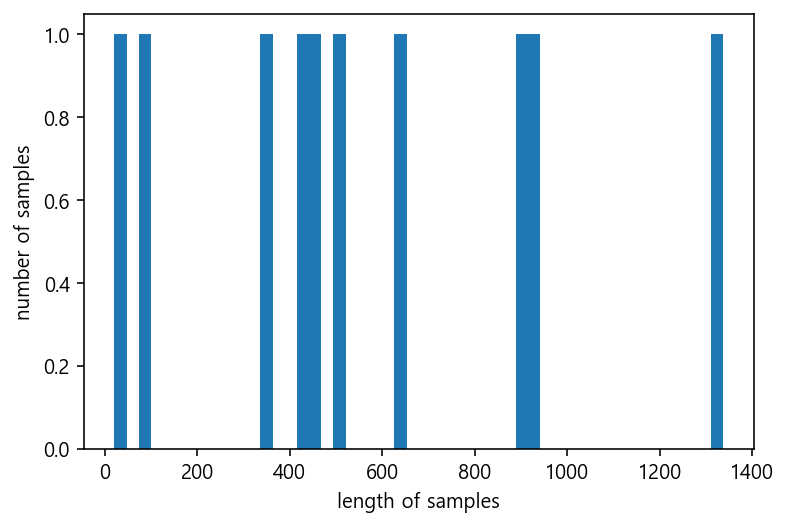

In [33]:
print('기사 최대길이 :',max(len(l) for l in tokenized_data))
print('기사 평균 길이 :',sum(map(len, tokenized_data))/len(tokenized_data))
plt.hist([len(s) for s in tokenized_data], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [35]:
import gensim
from gensim.models import Word2Vec

##### word2vec로  위의 기사로 모델형성

In [43]:
model = Word2Vec(sentences = tokenized_data, size = 100, window = 5, min_count = 5, workers = 4, sg = 0)

In [44]:
# 테이스 데이터 
# 더많은 기사로 돌리고 싶었지만, 500기사 if-idf값 추출도 4시간 넘게 걸림
model.wv.vectors.shape

(288, 100)

In [38]:
print(model.wv.most_similar("한국"))

[('장관', 0.5778898000717163), ('이후', 0.5573886632919312), ('않다', 0.5504796504974365), ('진자', 0.5503842830657959), ('씨', 0.5287003517150879), ('노동조합', 0.5232106447219849), ('전', 0.5167557597160339), ('방역', 0.5132301449775696), ('때', 0.5128638744354248), ('최', 0.5114469528198242)]


#### 한국 위키백과 Word2vec 모델과 비교

In [45]:
model = gensim.models.Word2Vec.load('C:\code\practice\deep-learning\ko\ko.bin')

In [47]:
model.wv.vectors.shape

(30185, 200)

In [46]:
result = model.wv.most_similar("한국")
print(result)

[('대한민국', 0.6662065982818604), ('우리나라', 0.6312342882156372), ('동양', 0.5589770078659058), ('미국', 0.5445789098739624), ('동북아', 0.5333539247512817), ('국내', 0.5278753638267517), ('일본', 0.5174024105072021), ('아세아', 0.5054686069488525), ('중국', 0.5036405920982361), ('민간', 0.5017623901367188)]


In [14]:
import pandas as pd
from math import log

In [2]:
df = pd.read_csv('datas/pressian_df.csv')
df = df.drop(['Unnamed: 0'], axis=1)
df.tail()

press_agency category                                            link  \
6518     pressian  culture  https://www.pressian.com/pages/articles/222931   
6519     pressian  culture  https://www.pressian.com/pages/articles/222590   
6520     pressian  culture  https://www.pressian.com/pages/articles/222177   
6521     pressian  culture  https://www.pressian.com/pages/articles/222094   
6522     pressian  culture  https://www.pressian.com/pages/articles/221886   

                               title  \
6518  1945년 8월 15일, '선출되지 않은 권력'의 탄생   
6519   "안된다는 걸 알면서도...야식을 참을 수가 없어요"   
6520     정치가 세종(世宗)을 통해 본 정치가 정조(正祖)   
6521             중국 유교 문화를 향한 냉정한 촌평   
6522          먼저 견뎌낸 '언니'의 혐오 사회 돌파기   

                                                content  \
6518  1945년 8월 15일, '선출되지 않은 권력'의 탄생정기후원 일본 천황의 항복방송...   
6519  "안된다는 걸 알면서도...야식을 참을 수가 없어요"정기후원 진료를 하다보면 병증의...   
6520  정치가 세종(世宗)을 통해 본 정치가 정조(正祖)정기후원 세종을 연구하던 저자가 다...   
6521  중국 유교 문화를 향한 냉정한 촌평정기후원 선종의 역사를 여지없이 깨부수는 모리 미...   
6522  먼저 견뎌낸 '언니'의 혐오 사회 돌파기정기후원 이 책은 두 가지의 포인트를 잡고 ...   

                     p_date img  
6518  2 0 1 8 . 1 2 . 2 8 .   -  
6519  2 0 1 8 . 1 2 . 2 6 .   -  
6520  2 0 1 8 . 1 2 . 2 2 .   -  
6521  2 0 1 8 . 1 2 . 2 1 .   -  
6522  2 0 1 8 . 1 2 . 2 0 .   -

In [4]:
prsian_df = df
article = prsian_df['content']
pd.set_option('display.max_rows',1000)
pd.set_option('display.max_columns',1000)
pd.set_option('display.width',1000)

##### 기사 TF-ODF 구현하기

##### 기사전처리  <- 실제로 적용안됨;;
- 명사, 알파벳, 숫자만 남도록 전처리

In [50]:

def dokenizer(raw, pos=['Noun', "Alpha", "Number"], stopword=[]):
    return [
        word for word, tag in okt.pos(
        raw, 
        norm=True,
        stem=True
        )
        if len(word) > 1 and tag in pos and word not in stopword
    ]

In [51]:
# split()로 기사 띄어쓰기로 구분
content = list(set(doc for con in article[:100] for doc in con.split() ))
content

['이름이',
 '개개인이',
 '고객들에게는',
 '올린다.',
 "기획추진단'도",
 '출범했기',
 '평가다.',
 '올라가서',
 '보호조치하고,',
 '증인이다.',
 '시기"에',
 '대면회의와',
 '상의나',
 '눈먼',
 '비율',
 '원은',
 '재무부',
 '가입한다는',
 '수익만',
 '사용자들은',
 '경마기수의',
 '첫날이나',
 '변화가',
 '공동정범으로',
 '근무로',
 '명과',
 '재유행의',
 '않기',
 '끼어',
 '작업장,',
 '삭제되고',
 '입찰액이',
 '자발적',
 '삼척시',
 '평가',
 '낮다.',
 '지원이',
 '미프진을',
 '비교를',
 '않겠노라고',
 "누군가'가",
 '은행과',
 '나옴에',
 '담당',
 '보고',
 '위원회를',
 '수정헌법',
 '그것이',
 '뜻하지',
 '회피한다.',
 '사건이',
 '직장',
 '개정되었다고',
 '주문한',
 '리모델링',
 '유권자',
 '감염"이',
 '참여인원은',
 '이해',
 '붙는',
 '29살',
 '실행하고',
 '합법',
 '퇴행과',
 '교섭창구단일화제도는',
 '거취에',
 '미군정이',
 "'가사와",
 '신중을',
 '입사자다.',
 '메인',
 '가파르다.',
 '있는가?',
 '도중',
 '확인됐기',
 '휴가를',
 '245명이었고',
 '가격도',
 '욕심을',
 '곳으로',
 '수용할',
 '차원의',
 '연구팀',
 '음악도',
 '필기시험,',
 '보이지',
 '급하게',
 '참관했고,',
 '미취학',
 '요인이자',
 '이상의',
 '‘토건족’의',
 '보전',
 '관중',
 '관련자',
 '교섭단체',
 '상속세를',
 '기분이',
 '노동자들을',
 '회장과',
 '343명을',
 '민주화되니까',
 '“오가며',
 '48.02%는',
 '유행의)',
 '미만일',
 '외치기도',
 '단체행동권을',
 '이슈를',
 "'왜",
 '생존자들이,',
 '점으로',
 '명절이면',
 '나날이',
 '가져

#### tf/idf/TF-idf 함수 정의
- tf : 특정 문서에서의 특정단어 t의 등장 횟수
- idf: df(특정 단어 t가 등장한 문서의 수)값의 역수 
$$ idf(d,t) = log(\frac{n}{1+df(t)}) $$
log를 사용 하지 않을 경우 n이 커질 수록, idf값이 기하 급수적으로 커짐

In [52]:
N = len(article[:10])

def tf(t, d):
    return d.count(t)

def idf(t):
    df = 0
    for con in article[:10]:
        df += t in con
    return log(N/(df + 1))

def tfidf(t, d):
    return tf(t,d) * idf(t)

In [53]:
# tf값
result = []
for i in range(N):
    result.append([])
    d =  article[:10][i]
    for j in range(len(content)):
        t = content[j]
        result[-1].append(tf(t, d))
        
tf_ = pd.DataFrame(result, columns = content)
tf_

이름이  개개인이  고객들에게는  올린다.  기획추진단'도  출범했기  평가다.  올라가서  보호조치하고,  증인이다.  시기"에  대면회의와  상의나  눈먼  비율  원은  재무부  가입한다는  수익만  사용자들은  경마기수의  첫날이나  변화가  공동정범으로  근무로  명과  재유행의  않기  끼어  작업장,  삭제되고  입찰액이  자발적  삼척시  평가  낮다.  지원이  미프진을  비교를  않겠노라고  누군가'가  은행과  나옴에  담당  보고  위원회를  수정헌법  그것이  뜻하지  회피한다.  사건이  직장  개정되었다고  주문한  리모델링  유권자  감염"이  참여인원은  이해  붙는  29살  실행하고  합법  퇴행과  교섭창구단일화제도는  거취에  미군정이  '가사와  신중을  입사자다.  메인  가파르다.  있는가?  도중  확인됐기  휴가를  245명이었고  가격도  욕심을  곳으로  수용할  차원의  연구팀  음악도  필기시험,  보이지  급하게  참관했고,  미취학  요인이자  이상의  ‘토건족’의  보전  관중  관련자  교섭단체  상속세를  기분이  노동자들을  회장과  343명을  민주화되니까  “오가며  48.02%는  유행의)  미만일  외치기도  단체행동권을  이슈를  '왜  생존자들이,  점으로  명절이면  나날이  가져간  땅의  성폭력은  선택해  2년을  억압의  유죄로  서울시의  C로,  8월에  노동운동의  경주마에  단순화했다.  '아빠가  형태  그토록  추진하고자  '뚜껑  사망한  성동구  문제였다.  제출됐다.  잃어버리고  울먹거리기도  표가  아시아  5명(5명  남동구  피통치자로서  물의  좋았을까요?"라는  줄이는  탈퇴서가  생각한다면,  주장대로  1만원'  부여하고자  손으로  됐다는  배상을  정신적으로  거래처  367명으로  모호해지고  자체"라며  소식은  헌법에  모더나를  바로잡기  되고  차지하고  중수본-중대본  교육구조가  말씀드립니다.  지는  마무리단계로  \
0    0     0       0     0        0     0     0     0        0      0     0      0    0   0   0   0    0      0    0      0      0     0    0       0    0   0     0   0   0     0     0     0    0    0   0    0    0     0    0      0      0    0    0   1   1     0     0    0    0      0    0   0       0    0     0    0     0      0   0   0    0     0   0    0           0    0     0     0    0      0   0      0     0   0     0    0        0    0    0    0    0    0    0    0      0    0    0      0    0     0    0       0   0   0    0     0     0    0      0    0      0       0     0        0     0    0     0       0    0   0       0    0     0    0    0   0     0    0    0    0    0     0    0    1      0     2       0     0   0    0      0    0    0    0      0      0      0       0   0    1      0    0       0   1          0    1     0       0     0     0      0    0    0    0      0    0       0      0      0    0    0     0     0   0     0        0      0        0   1       0   
1    0     0       0     0        0     0     0     0        0      0     0      0    0   0   0   0    0      0    0      0      0     0    0       0    0   0     0   0   0     0     0     0    0    0   0    0    0     0    0      0      0    0    0   0   0     0     0    0    0      0    0   0       0    0     0    0     0      0   0   0    0     0   0    0           0    0     0     0    0      0   0      0     0   0     0    0        0    0    0    0    0    0    0    0      0    0    0      0    0     0    0       0   0   0    0     0     0    0      0    0      0       0     0        0     0    0     0       0    0   0       0    0     0    0    0   0     0    0    0    0    0     0    0    0      0     0       0     0   3    0      1    0    0    0      0      0      0       0   0    0      0    0       0   0          0    0     0       0     0     0      0    0    0    0      0    0       0      0      0    0    0     0     0   1     0        0      0        0   0       0   
2    0     0       0     0        0     0     0     0        0      0     0      0    0   0   0   0    0      0    0      0      0     0    0       0    0   1     0   0   0     0     0     0    0    0   0    0    0     0    0      0      0    0    0   0   9     0     0    0    0      0    0   0       0    0     0    0     0      0   0   0    0     0   0    0           0    0     0     0    0      0   0      0     0   0     0    0        0    0    0    0    0    0    0    0      0    0    0      0    0     0    0       0   0   0    0     0     0    0      0    0      0       0     0        0     0    0     0       0    0   0       0    0     0    0    0   0     0    0    0    0    0     0    0    0      0     0       0     0   0    0      0    0    0    0      0      0      0       0   0    0      0    0       0   0          0    0     0       0     0     0      0    0    0    0      0    0       0      0      0    0    0     0     0   0     0        0      0        0   0       0   
3    0     0   

In [15]:
result = []
for j in range(len(content)):
    t = content[j]
    result.append(idf(t))
    
idf_ = pd.DataFrame(result, index = content, columns = ["IDF"])
idf_

IDF
이름이      2.302585
개개인이     2.302585
고객들에게는   2.302585
올린다.     2.302585
기획추진단'도  2.302585
...           ...
이보다      2.302585
통제·관리의   2.302585
뿌듯했다.    2.302585
만드는데     2.302585
머무르게     2.302585

[29008 rows x 1 columns]

In [17]:
result = []
for i in range(N):
    result.append([])
    d = article[:10][i]
    for j in range(len(content)):
        t = content[j]
        
        result[-1].append(tfidf(t,d))
        
tfidf_ = pd.DataFrame(result, columns = content)
tfidf_

이름이  개개인이  고객들에게는  올린다.  기획추진단'도      출범했기  평가다.  올라가서  보호조치하고,  증인이다.  시기"에  대면회의와  상의나   눈먼   비율   원은  재무부  가입한다는  수익만  사용자들은  경마기수의  첫날이나       변화가    공동정범으로  근무로        명과  재유행의   않기   끼어  작업장,  삭제되고  입찰액이  자발적  삼척시        평가  낮다.  지원이  미프진을  비교를  않겠노라고  누군가'가  은행과  나옴에        담당        보고  위원회를  수정헌법       그것이  뜻하지  회피한다.       사건이   직장  개정되었다고  주문한  리모델링  유권자  감염"이  참여인원은        이해   붙는  29살  실행하고   합법  퇴행과  교섭창구단일화제도는  거취에  미군정이  '가사와  신중을  입사자다.   메인  가파르다.  있는가?   도중  확인됐기  휴가를  245명이었고  가격도  욕심을       곳으로  수용할  차원의  연구팀  음악도  필기시험,       보이지  급하게  참관했고,  미취학  요인이자  이상의  ‘토건족’의   보전   관중  관련자  교섭단체  상속세를  기분이     노동자들을  회장과  343명을  민주화되니까  “오가며  48.02%는  유행의)  미만일  외치기도  단체행동권을  이슈를   '왜  생존자들이,  점으로  명절이면  나날이  가져간   땅의  성폭력은  선택해  2년을  억압의  유죄로  서울시의  C로,       8월에  노동운동의      경주마에  단순화했다.  '아빠가        형태  그토록     추진하고자  '뚜껑  사망한  성동구  문제였다.  제출됐다.  잃어버리고  울먹거리기도        표가       아시아  5명(5명  남동구  피통치자로서        물의  좋았을까요?"라는       줄이는  탈퇴서가  생각한다면,  주장대로  1만원'  부여하고자  \
0  0.0   0.0     0.0   0.0      0.0  0.000000   0.0   0.0      0.0    0.0   0.0    0.0  0.0  0.0  0.0  0.0  0.0    0.0  0.0    0.0    0.0   0.0  0.000000  0.000000  0.0  0.000000   0.0  0.0  0.0   0.0   0.0   0.0  0.0  0.0  0.000000  0.0  0.0   0.0  0.0    0.0    0.0  0.0  0.0  1.609438  0.510826   0.0   0.0  0.000000  0.0    0.0  0.000000  0.0     0.0  0.0   0.0  0.0   0.0    0.0  0.000000  0.0  0.0   0.0  0.0  0.0    0.000000  0.0   0.0   0.0  0.0    0.0  0.0    0.0   0.0  0.0   0.0  0.0      0.0  0.0  0.0  0.000000  0.0  0.0  0.0  0.0    0.0  0.000000  0.0    0.0  0.0   0.0  0.0     0.0  0.0  0.0  0.0   0.0   0.0  0.0  0.000000  0.0    0.0     0.0   0.0      0.0   0.0  0.0   0.0     0.0  0.0  0.0     0.0  0.0   0.0  0.0  0.0  0.0   0.0  0.0  0.0  0.0  0.0   0.0  0.0  1.609438    0.0  3.218876     0.0   0.0  0.000000  0.0  0.000000  0.0  0.0  0.0    0.0    0.0    0.0     0.0  0.000000  1.609438    0.0  0.0     0.0  0.916291        0.0  1.609438   0.0     0.0   0.0   0.0    0.0   
1  0.0   0.0     0.0   0.0      0.0  0.000000   0.0   0.0      0.0    0.0   0.0    0.0  0.0  0.0  0.0  0.0  0.0    0.0  0.0    0.0    0.0   0.0  0.000000  0.000000  0.0  0.000000   0.0  0.0  0.0   0.0   0.0   0.0  0.0  0.0  0.000000  0.0  0.0   0.0  0.0    0.0    0.0  0.0  0.0  0.000000  0.000000   0.0   0.0  0.000000  0.0    0.0  0.000000  0.0     0.0  0.0   0.0  0.0   0.0    0.0  0.000000  0.0  0.0   0.0  0.0  0.0    0.000000  0.0   0.0   0.0  0.0    0.0  0.0    0.0   0.0  0.0   0.0  0.0      0.0  0.0  0.0  0.000000  0.0  0.0  0.0  0.0    0.0  0.000000  0.0    0.0  0.0   0.0  0.0     0.0  0.0  0.0  0.0   0.0   0.0  0.0  0.000000  0.0    0.0     0.0   0.0      0.0   0.0  0.0   0.0     0.0  0.0  0.0     0.0  0.0   0.0  0.0  0.0  0.0   0.0  0.0  0.0  0.0  0.0   0.0  0.0  0.000000    0.0  0.000000     0.0   0.0  3.611918  0.0  1.609438  0.0  0.0  0.0    0.0    0.0    0.0     0.0  0.000000  0.000000    0.0  0.0     0.0  0.000000        0.0  0.000000   0.0     0.0   0.0   0.0    0.0   
2  0.0   0.0     0.0   0.0      0.0  0.000000   0.0   0.0      0.0    0.0   0.0    0.0  0.0  0.0  0.0  0.0  0.0    0.0  0.0    0.0    0.0   0.0  0.000000  0.000000  0.0  0.916291   0.0  0.0  0.0   0.0   0.0   0.0  0.0  0.0  0.000000  0.0  0.0   0.0  0.0    0.0    0.0  0.0  0.0  0.000000  4.597431   0.0   0.0  0.000000  0.0    0.0  0.000000  0.0     0.0  0.0   0.0  0.0   0.0    0.0  0.000000  0.0  0.0   0.0  0.0  0.0    0.000000  0.0   0.0   0.0  0.0    0.0  0.0    0.0   0.0  0.0   0.0  0.0      0.0  0.0  0.0  0.000000  0.0  0.0  0.0  0.0    0.0  0.000000  0.0    0.0  0.0   0.0  0.0     0.0  0.0  0.0  0.0   0.0   0.0  0.0  0.000000  0.0    0.0     0.0   0.0      0.0   0.0  0.0   0.0     0.0  0.0  0.0     0.0  0.0   0.0  0.0  0.0  0.0   0.0  0.0  0.0  0.0  0.0   0.0  0.0  0.000000    0.0  0.000000     0.0   0.0  0.000000  0.0  0.000000  0.0  0.0  0.0    0.0    0.0    0.0     0.0  0.000000  0.000000    0.0  0.0     0.0  0.000000        0.0  0.000000   0.0     0.0   0.0   0.0    0.0   
3  0.0   0.0   

In [19]:
pd.set_option('display.max_rows',1000)
pd.set_option('display.max_columns',1000)

### K-mean 군집화 및 countVectorizer
- K값은(군집화수) $$\frac{\sqrt{\frac{2}{n}}}{2}$$ 로 한다.

In [3]:
# 기사전처리 후, 'con_cleaned'멀럼 생성
import re
import sys
def preprocessing(sentence):
    sentence = re.sub('[^가-힣ㄱ-ㅎㅏ-ㅣa-zA-Z]', ' ', sentence)
    return sentence

df['con_cleaned'] = df['content'].apply(preprocessing)
content = df['con_cleaned'].tolist()

In [4]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import normalize
from sklearn.cluster import KMeans

n_clusters = 30

vectorizer = CountVectorizer()
X = vectorizer.fit_transform(content)

X = normalize(X)

kmeans= KMeans(n_clusters=n_clusters).fit(X)

labels = kmeans.labels_
centers = kmeans.cluster_centers_

df['labels'] = labels

#### Kmeans 군집화

In [5]:
df.loc[df['labels']==2,['con_cleaned','labels']]

con_cleaned  labels
59      양진호 웹하드 에선 여전히 불법 영상물이 대량 유포되고 있다 정기후원  웹하드 ...       2
74      년대생 노동자가 말했다    이 바닥은  쌍팔년도 예요 정기후원  동료들의 출퇴...       2
94    피자집 사장님이 파워 슈퍼 울트라에 돈 뜯기다 결국 배달원 된 사연정기후원     ...       2
132   조리시간   분인데    분만에 만들어    배달앱 배만 불려주는  사장님 들정기후...       2
143   혁신의  뽕  배달앱  법과 규제마저 무력화한다정기후원        명지대 앞   ...       2
...                                                 ...     ...
6456      불한당들의 시대정기후원    길달문     왕은 혼인을 서둘렀다  복승   ...       2
6458      불한당들의 시대정기후원 사도태후는 특별히 새주    라는 자리를 만들어 미실...       2
6461     불한당들의 시대정기후원 그날 밤 서라벌     은 전례 없이 소란했다 선도산의...       2
6466      불한당들의 시대정기후원 알천과 한신이 여근곡을 향하고 있을 즈음   올해도 ...       2
6469      불한당들의 시대정기후원 날이 밝았으나 내관은 여전히 안절부절 하였다  대궁 ...       2

[151 rows x 2 columns]

In [6]:
df.loc[df['labels'],['con_cleaned','labels']]

con_cleaned  labels
4   문중원  주기 추모제   먼저 간 자식 영정에 잔 올린 부모정기후원 마사회의 비리와...      24
3   범죄가 문화라고   강간문화 는 실재한다정기후원                    ...       5
8   검찰   요양급여 부정 수급  윤석열 장모 불구속기소정기후원 불법 요양병원 개설과 ...      16
5    대권후보 거론돼 위엄 상실   추미애  윤석열 직무배제정기후원 추미애 법무부 장관...      15
24  교회를 사회 복지 시설로 운영할 수 있다면정기후원 겨울이 다가오자 코로나   다시 ...       4
..                                                ...     ...
6    헤어진 남친이 사귈 때 찍은 영상을 지우지 않은 것 같아요 정기후원  누군가의 특...      23
7   헤아리기 어려운정기후원 헤아리기 어려웠다 아들이 먼저 죽는다는 것은    사랑하던 ...       9
4   문중원  주기 추모제   먼저 간 자식 영정에 잔 올린 부모정기후원 마사회의 비리와...      24
6    헤어진 남친이 사귈 때 찍은 영상을 지우지 않은 것 같아요 정기후원  누군가의 특...      23
23  코로나  젊은 확진자  증가세가 가파르다정기후원 코로나  가 동절기 들어 빠른 속도...       3

[6523 rows x 2 columns]

In [7]:
kmeans_df =  df.groupby(by=['labels'],as_index=False).count()

In [8]:
kmeans_df.loc[:,['con_cleaned','labels']]

con_cleaned  labels
0            59       0
1           120       1
2           151       2
3           279       3
4           484       4
5           180       5
6           374       6
7           151       7
8           155       8
9           701       9
10           56      10
11          164      11
12          134      12
13          264      13
14          634      14
15          139      15
16          272      16
17           46      17
18          214      18
19          470      19
20           62      20
21           38      21
22           16      22
23          698      23
24          162      24
25           26      25
26          157      26
27           69      27
28          138      28
29          110      29

##### 라벨별 문서(기사)개수

In [9]:
kmeans_df = kmeans_df.loc[:,['labels','con_cleaned']]
kmeans_df

labels  con_cleaned
0        0           59
1        1          120
2        2          151
3        3          279
4        4          484
5        5          180
6        6          374
7        7          151
8        8          155
9        9          701
10      10           56
11      11          164
12      12          134
13      13          264
14      14          634
15      15          139
16      16          272
17      17           46
18      18          214
19      19          470
20      20           62
21      21           38
22      22           16
23      23          698
24      24          162
25      25           26
26      26          157
27      27           69
28      28          138
29      29          110

In [11]:
C, L  = kmeans_df['con_cleaned'], kmeans_df['labels']

In [23]:
# 이거 어떻게 하나요 ㅜ;;
print('{}그룹의 개수는 {}개'.format(kmeans_df['labels'],kmeans_df['con_cleaned']))

0      0
1      1
2      2
3      3
4      4
5      5
6      6
7      7
8      8
9      9
10    10
11    11
12    12
13    13
14    14
15    15
16    16
17    17
18    18
19    19
20    20
21    21
22    22
23    23
24    24
25    25
26    26
27    27
28    28
29    29
Name: labels, dtype: int64그룹의 개수는 0      59
1     120
2     151
3     279
4     484
5     180
6     374
7     151
8     155
9     701
10     56
11    164
12    134
13    264
14    634
15    139
16    272
17     46
18    214
19    470
20     62
21     38
22     16
23    698
24    162
25     26
26    157
27     69
28    138
29    110
Name: con_cleaned, dtype: int64개


In [16]:
kmeans_df.tail()

labels  con_cleaned
25      25           26
26      26          157
27      27           69
28      28          138
29      29          110

In [17]:
from nltk.tokenize import sent_tokenize
from nltk.tokenize import WordPunctTokenizer
tokenizer = WordPunctTokenizer()
from konlpy.tag import Hannanum
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

In [18]:
vectorizer = CountVectorizer(stop_words = ['의', '가', '이', '은', '들', '는', '좀', '잘', '과', '도', '를', '으로' ,'자' ,'에' , '것', '까지', '을', '적', "'", '수',
             '와', '한', '하다', '에는', '것은', '에게', '관','.', '로', '인', '경우', '권', '하', ')', '(', '"', '중', '이다', ',','되다','하고',
              '되다', '에서', '김', '통해', '김', ' 명', '있다', '없다', '중', '돼다', '받다', '따르다', '장', '명', '아니다', 
            ])
X = vectorizer.fit_transform(kmeans_df)
print(vectorizer.get_feature_names())

['con_cleaned', 'labels']


In [19]:
print(vectorizer.get_stop_words())

frozenset({'의', '되다', '에는', "'", '에', '(', ' 명', '에서', '들', '수', '장', '이', '것', '있다', '경우', '받다', '에게', '는', '하', '을', '없다', '적', '권', '하다', '한', '중', '가', '좀', '통해', ',', '명', '과', '이다', '하고', '돼다', '따르다', '관', '김', '은', '로', '.', '아니다', '것은', '도', '까지', ')', '를', '"', '으로', '잘', '인', '자', '와'})


In [20]:
print(X.shape)

(2, 2)


In [21]:
vectorizer = CountVectorizer(
    tokenizer = tokenizer,
    min_df=2
)

In [22]:
print(vectorizer)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=None, min_df=2,
                ngram_range=(1, 1), preprocessor=None, stop_words=None,
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=WordPunctTokenizer(pattern='\\w+|[^\\w\\s]+', gaps=False, discard_empty=True, flags=<RegexFlag.UNICODE|DOTALL|MULTILINE: 56>),
                vocabulary=None)


### wordcloud

In [73]:
from konlpy.tag import Twitter
from collections import Counter

In [71]:
lists = tfidf_.columns.tolist()
lists

['이름이',
 '개개인이',
 '고객들에게는',
 '올린다.',
 "기획추진단'도",
 '출범했기',
 '평가다.',
 '올라가서',
 '보호조치하고,',
 '증인이다.',
 '시기"에',
 '대면회의와',
 '상의나',
 '눈먼',
 '비율',
 '원은',
 '재무부',
 '가입한다는',
 '수익만',
 '사용자들은',
 '경마기수의',
 '첫날이나',
 '변화가',
 '공동정범으로',
 '근무로',
 '명과',
 '재유행의',
 '않기',
 '끼어',
 '작업장,',
 '삭제되고',
 '입찰액이',
 '자발적',
 '삼척시',
 '평가',
 '낮다.',
 '지원이',
 '미프진을',
 '비교를',
 '않겠노라고',
 "누군가'가",
 '은행과',
 '나옴에',
 '담당',
 '보고',
 '위원회를',
 '수정헌법',
 '그것이',
 '뜻하지',
 '회피한다.',
 '사건이',
 '직장',
 '개정되었다고',
 '주문한',
 '리모델링',
 '유권자',
 '감염"이',
 '참여인원은',
 '이해',
 '붙는',
 '29살',
 '실행하고',
 '합법',
 '퇴행과',
 '교섭창구단일화제도는',
 '거취에',
 '미군정이',
 "'가사와",
 '신중을',
 '입사자다.',
 '메인',
 '가파르다.',
 '있는가?',
 '도중',
 '확인됐기',
 '휴가를',
 '245명이었고',
 '가격도',
 '욕심을',
 '곳으로',
 '수용할',
 '차원의',
 '연구팀',
 '음악도',
 '필기시험,',
 '보이지',
 '급하게',
 '참관했고,',
 '미취학',
 '요인이자',
 '이상의',
 '‘토건족’의',
 '보전',
 '관중',
 '관련자',
 '교섭단체',
 '상속세를',
 '기분이',
 '노동자들을',
 '회장과',
 '343명을',
 '민주화되니까',
 '“오가며',
 '48.02%는',
 '유행의)',
 '미만일',
 '외치기도',
 '단체행동권을',
 '이슈를',
 "'왜",
 '생존자들이,',
 '점으로',
 '명절이면',
 '나날이',
 '가져

In [74]:
twitter = Twitter()
morphs = []

for sentence  in  lists:
    morphs.append(twitter.pos(sentence))
print(morphs)

C:\Users\oaqqa\anaconda3\lib\site-packages\konlpy\tag\_okt.py:16: UserWarning: "Twitter" has changed to "Okt" since KoNLPy v0.4.5.
  warn('"Twitter" has changed to "Okt" since KoNLPy v0.4.5.')


[[('이름', 'Noun'), ('이', 'Josa')], [('개개인', 'Noun'), ('이', 'Josa')], [('고객', 'Noun'), ('들', 'Suffix'), ('에게는', 'Josa')], [('올린다', 'Noun'), ('.', 'Punctuation')], [('기획', 'Noun'), ('추진단', 'Noun'), ("'", 'Punctuation'), ('도', 'Noun')], [('출범', 'Noun'), ('했기', 'Verb')], [('평가', 'Noun'), ('다', 'Josa'), ('.', 'Punctuation')], [('올라가서', 'Verb')], [('보호', 'Noun'), ('조치', 'Noun'), ('하고', 'Josa'), (',', 'Punctuation')], [('증인', 'Noun'), ('이다', 'Josa'), ('.', 'Punctuation')], [('시기', 'Noun'), ('"', 'Punctuation'), ('에', 'Josa')], [('대면', 'Noun'), ('회의', 'Noun'), ('와', 'Josa')], [('상의', 'Noun'), ('나', 'Josa')], [('눈', 'Noun'), ('먼', 'Adjective')], [('비율', 'Noun')], [('원', 'Noun'), ('은', 'Josa')], [('재무부', 'Noun')], [('가입', 'Noun'), ('한다는', 'Modifier')], [('수익', 'Noun'), ('만', 'Josa')], [('사용자', 'Noun'), ('들', 'Suffix'), ('은', 'Josa')], [('경마', 'Noun'), ('기', 'Modifier'), ('수의', 'Noun')], [('첫날', 'Noun'), ('이나', 'Josa')], [('변화', 'Noun'), ('가', 'Josa')], [('공', 'Modifier'), ('동', 'Modifier'), ('정범'

In [75]:
noun_adj_adv_list=[]
for sentence in morphs:
    for word, tag in sentence:
        if tag in ['Noun'] and ('것' not in word) and ('내' not in word)and ('나' not in word)and ('수'not in word) and('게'not in word)and ('앙드레욱' not in word)and ('엽문' not in word)and ('곽' not in word)and ('태민' not in word)and ('종찬' not in word)and ('형님' not in word)and ('코치' not in word)and ('난' not in word)and ('저' not in word):
            noun_adj_adv_list.append(word)
            
print(noun_adj_adv_list)

['이름', '개개인', '고객', '올린다', '기획', '추진단', '도', '출범', '평가', '보호', '조치', '증인', '시기', '대면', '회의', '상의', '눈', '비율', '원', '재무부', '가입', '사용자', '경마', '첫날', '변화', '정범', '근무', '명과', '재', '유행', '작업장', '삭제', '입찰', '액', '자발', '삼척시', '평가', '지원이', '미프진', '비교', '누군가', '은행', '담당', '보고', '위원회', '헌법', '뜻', '회피', '사건', '직장', '개정', '주문', '리', '모델링', '유권자', '감염', '이', '참여', '인원', '이해', '살', '실행', '합법', '퇴행', '교섭', '창구', '단일', '제도', '거취', '미군정', '가사', '신중', '입사', '메인', '가파르', '도중', '확인', '휴가', '명', '가격', '욕심', '곳', '차원', '연구', '팀', '음악', '필기', '시험', '보이지', '참관', '미취', '학', '요인', '이자', '이상', '토건', '족', '의', '보전', '관중', '관련', '교섭단체', '상속세', '기분', '노동자', '회장', '명', '민주화', '유행', '미만', '일', '외치', '기도', '단체행동권', '이슈', '왜', '생존자', '점', '명절', '땅', '성폭력', '선택', '억압', '유죄', '서울시', '로', '노동운동', '경주마', '단순', '아빠', '형태', '추진', '뚜껑', '사망', '성동구', '문제', '제출', '기도', '표', '아시아', '명', '명', '남동구', '피', '통치', '로서', '물의', '탈퇴', '생각', '주장', '부여', '손', '배상', '정신', '거래처', '명', '자체', '라며', '소식', '헌법', '더', '차지', '중', '대본', '교육구', '조가

In [76]:
count = Counter(noun_adj_adv_list)

In [77]:
words = dict(count.most_common())

In [78]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords

In [79]:
%matplotlib inline

import matplotlib
from matplotlib import rc
rc('font', family='malgun')

In [80]:
from wordcloud import WordCloud

wordcloud = WordCloud(
    font_path = 'C:\Windows\Fonts\malgun.ttf',
    background_color='white',
    colormap = 'Accent_r',
    width = 800,
    height = 800
)
wordcloud_words = wordcloud.generate_from_frequencies(words)

<class 'numpy.ndarray'>
(800, 800, 3)


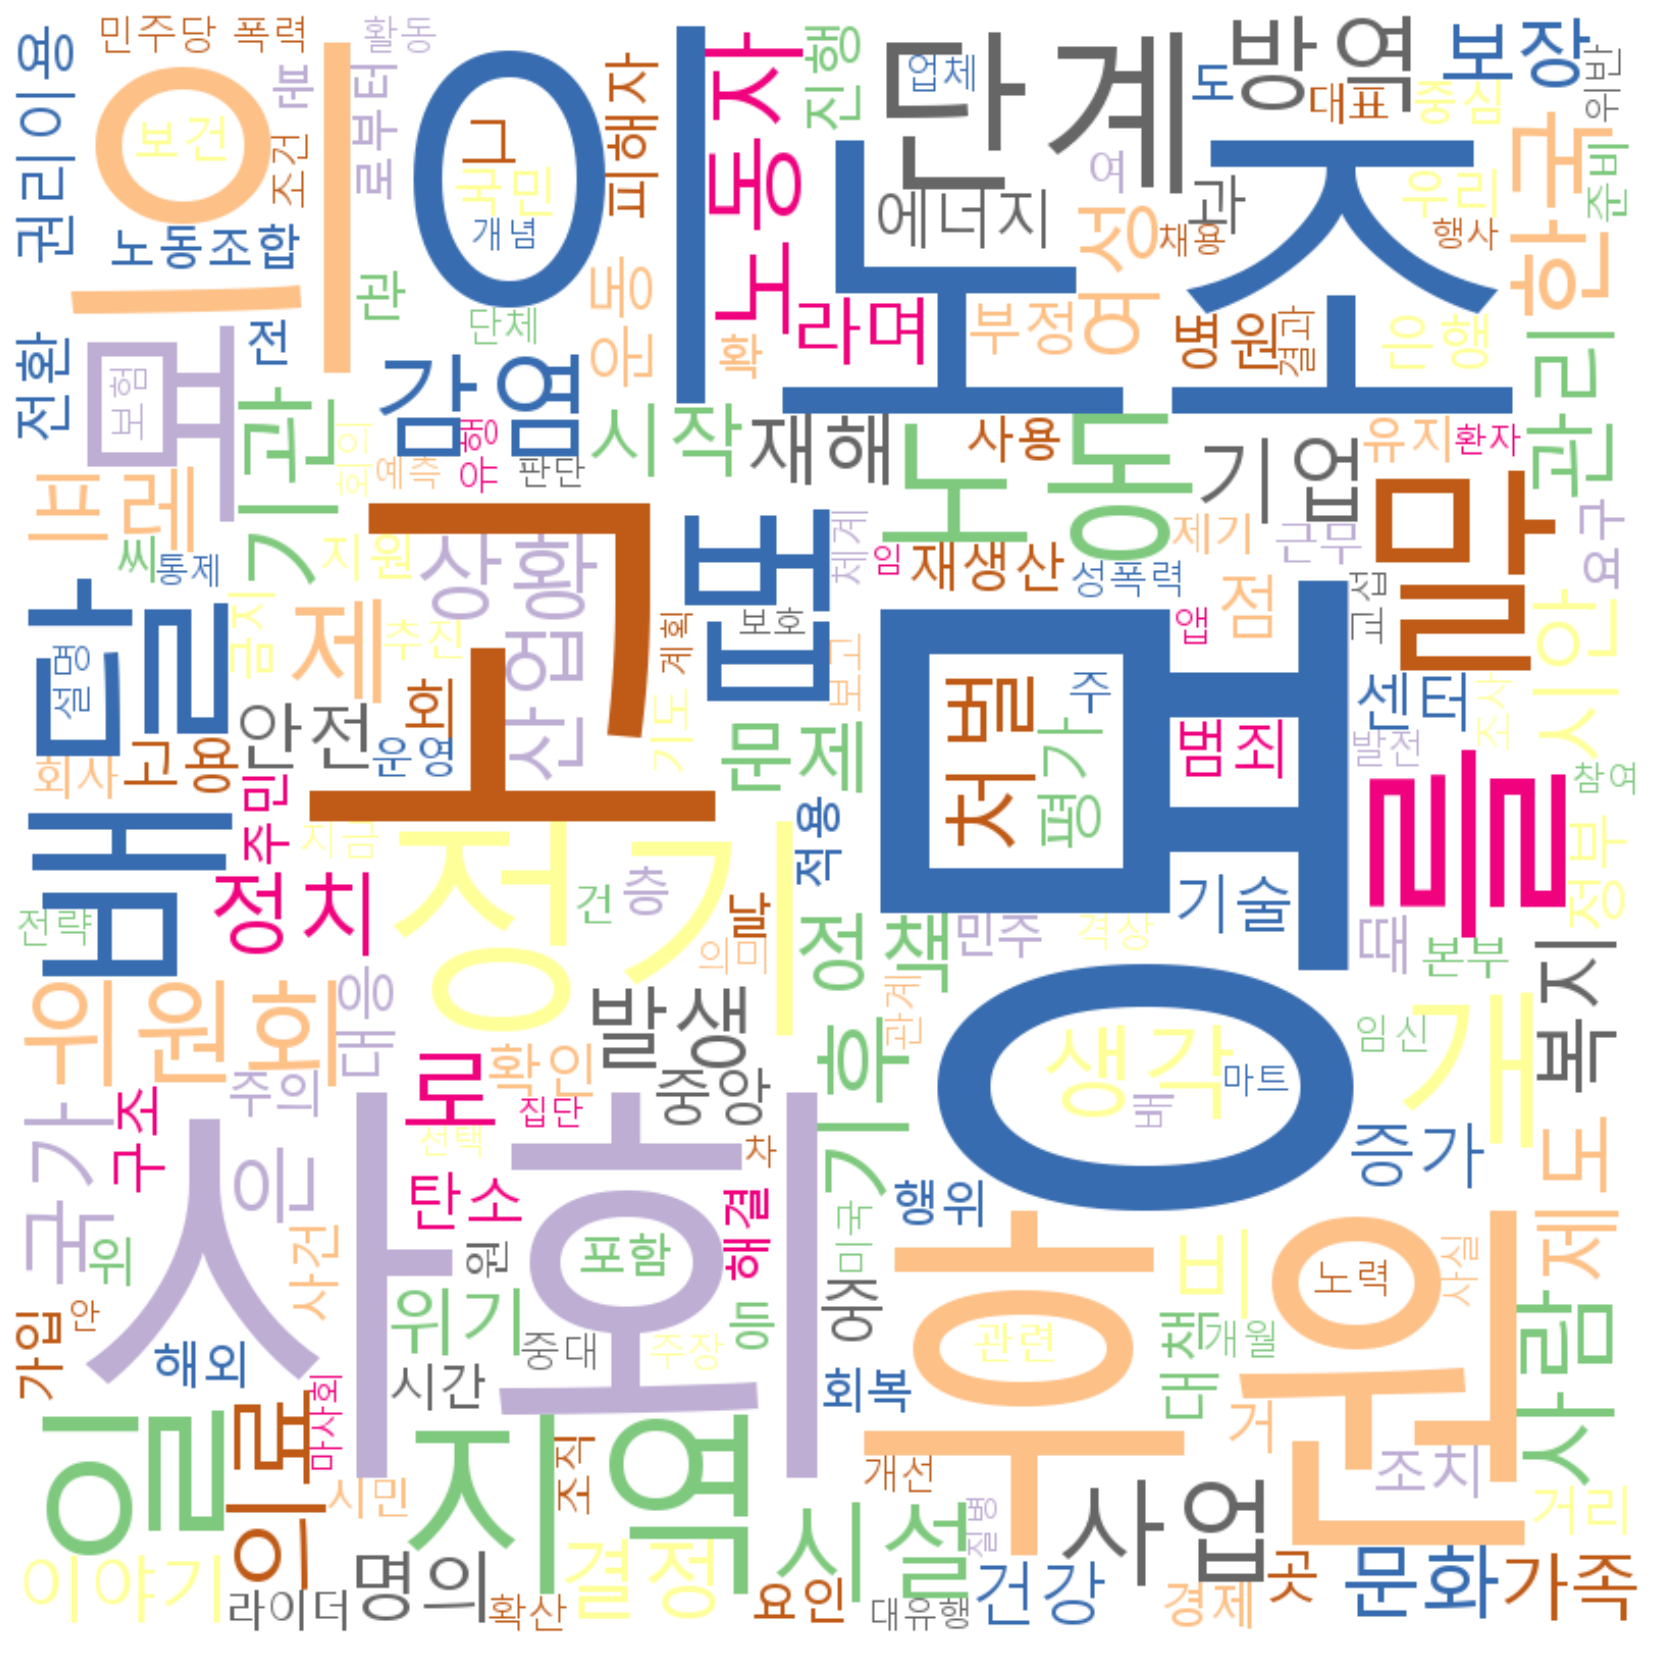

In [81]:
array = wordcloud.to_array()
print(type(array))
print(array.shape)

fig = plt.figure(figsize=(15,15))
plt.imshow(array, interpolation="bilinear")
plt.axis('off')
plt.show()
fig.savefig('business_anlytics_worldcloud.png')

### 자카드 유사성 및 코사인유사도

##### 유사성 측정 테스트 기사 

### 자카드 유사성
- 두 문장을 각각 단어의 집합으로 만든 뒤, 두 집합을 통해 유사도를 측정
$$ J(A,B) = \frac{\vert A\cap B \vert}{\vert A\cup B \vert} = \frac{\vert A\cap B \vert}{\vert A \vert + \vert B \vert - \vert A\cap B \vert} $$

In [86]:
# 100개의 기사가 반복됨
test = pd.read_csv('datas/test.csv')
test.tail(1)

Unnamed: 0 category                                            content                                               link                 p_date press_agency                              title
568         568  culture  코로나는 서막에 불과하다...기후위기와 팬데믹은 인권의 문제정기후원 기후위기는 과학...  https://www.pressian.com/pages/articles/202011...  2 0 2 0 . 1 1 . 2 1 .     pressian  코로나는 서막에 불과하다...기후위기와 팬데믹은 인권의 문제

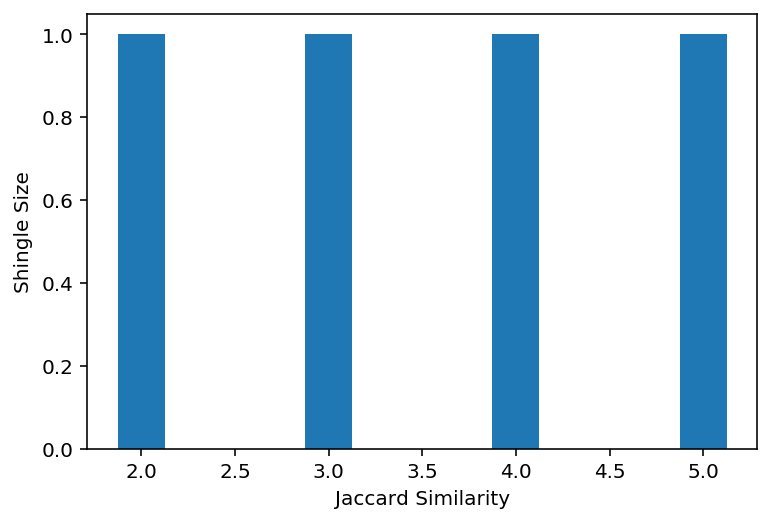

In [88]:
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns # makes the graph prettier

s1 = test['content'][0]
s2 = test['content'][201]

similarities = []
for shingle_size in range(2, 6):
    shingles1 = set([s1[max(0, i - shingle_size):i] for i in range(shingle_size, len(s1) + 1)])
    shingles2 = set([s2[max(0, i - shingle_size):i] for i in range(shingle_size, len(s2) + 1)])
    jaccard = len(shingles1 & shingles2) / len(shingles1 | shingles2)
    similarities.append(jaccard)

_ = plt.bar([2,3,4,5], similarities, width=0.25)
_ = plt.xlabel('Jaccard Similarity')
_ = plt.ylabel('Shingle Size')

#### 추출기사 유사성
- 중복된 기사끼리 비교했으므로 유사성 1이 나옴

In [90]:
s1 = test['content'][0]
s2 = test['content'][201]

shingles1 = set([s1[max(0, i-4):i] for i in range(4, len(s1) + 1)])
shingles2 = set([s2[max(0, i-4):i] for i in range(4, len(s2) + 1)])

len(shingles1 & shingles2) / len(shingles1 | shingles2)

1.0

#### 문제점
- 동일한 문자를 측정하여 중복기사를 추출하기 때문에, '나는 지하철을 타고 집에 간다.'와 '나는 지하철을 타고 집에 안간다.'가 유사성이 높게 나오는 문제점이 있다.


#### CountVectorizer를 이용한 유사성 높은 기사 추출 

In [93]:
df = pd.read_csv('datas/pressian_df.csv')
df = df.drop(['Unnamed: 0'], axis=1)
df.tail()

press_agency category                                            link                           title                                            content                 p_date img
6518     pressian  culture  https://www.pressian.com/pages/articles/222931  1945년 8월 15일, '선출되지 않은 권력'의 탄생  1945년 8월 15일, '선출되지 않은 권력'의 탄생정기후원 일본 천황의 항복방송...  2 0 1 8 . 1 2 . 2 8 .   -
6519     pressian  culture  https://www.pressian.com/pages/articles/222590   "안된다는 걸 알면서도...야식을 참을 수가 없어요"  "안된다는 걸 알면서도...야식을 참을 수가 없어요"정기후원 진료를 하다보면 병증의...  2 0 1 8 . 1 2 . 2 6 .   -
6520     pressian  culture  https://www.pressian.com/pages/articles/222177     정치가 세종(世宗)을 통해 본 정치가 정조(正祖)  정치가 세종(世宗)을 통해 본 정치가 정조(正祖)정기후원 세종을 연구하던 저자가 다...  2 0 1 8 . 1 2 . 2 2 .   -
6521     pressian  culture  https://www.pressian.com/pages/articles/222094             중국 유교 문화를 향한 냉정한 촌평  중국 유교 문화를 향한 냉정한 촌평정기후원 선종의 역사를 여지없이 깨부수는 모리 미...  2 0 1 8 . 1 2 . 2 1 .   -
6522     pressian  culture  https://www.pressian.com/pages/articles/221886          먼저 견뎌낸 '언니'의 혐오 사회 돌파기  먼저 견뎌낸 '언니'의 혐오 사회 돌파기정기후원 이 책은 두 가지의 포인트를 잡고 ...  2 0 1 8 . 1 2 . 2 0 .   -

In [94]:
ls = [df['content'][0]]

In [95]:
df['content'][:50]

0     미국, 영국, 호주에는 있는 경주마 복지법, 한국은 없다정기후원     세계 곳곳에...
1     코로나19로 복지관 휴관? 휴업 아닙니다!정기후원 내가 사는 서울시 도봉구에선 매년...
2     다시 300명대로...24일 코로나 새 확진자 349명정기후원 수도권의 사회적 거리...
3     범죄가 문화라고? '강간문화'는 실재한다정기후원                    ...
4     문중원 1주기 추모제...먼저 간 자식 영정에 잔 올린 부모정기후원 마사회의 비리와...
5     "대권후보 거론돼 위엄 상실"?…추미애, 윤석열 직무배제정기후원 추미애 법무부 장관...
6     "헤어진 남친이 사귈 때 찍은 영상을 지우지 않은 것 같아요"정기후원  누군가의 특...
7     헤아리기 어려운정기후원 헤아리기 어려웠다.아들이 먼저 죽는다는 것은... 사랑하던 ...
8     검찰, '요양급여 부정 수급' 윤석열 장모 불구속기소정기후원 불법 요양병원 개설과 ...
9     어용노조, 유령노조, 위성노조의 역습정기후원  10년 전 이 말을 들었을 때 사람들...
10    서울 홍대새교회 71명, 서초 사우나 60명...코로나 집단 감염 이어져정기후원 서...
11    문중원 기수의 뜻을 진정으로 잇는 길, 마사회법 개정정기후원     한국마사회 문중...
12    천태만상 사학 비리, 사학법 개정으로 바로잡아야 한다정기후원  이는 고종 8년 3월...
13    "운전기사 딸 살도 뺐는데.." 대구은행 3단계 점수조작정기후원 은행장이 왜 하필이...
14    "배민-요기요 결합하면 독과점 불공정 폐해 더 심각해질 것"정기후원 소상공인단체와 ...
15    코로나 개별·집단 감염 연쇄 고리..."올해 모임은 없다 생각해달라"정기후원 서울 ...
16    문중원 기수 1주기 "마사회의 '죽음의 경주'는 계속되고 있다"정기후원  마사회 부...
17    정은경 "연내 코로나 백신 3천만명분 확보 가능"정기후원 확보 여부로 논란이

In [96]:
import pandas as pd
pd.options.mode.chained_assignment = None
 
import numpy as np
np.random.seed(0)
 
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity

In [97]:
import re

def preprocessing(sentence):
    sentence = re.sub('[^가-힣ㄱ-ㅎㅏ-ㅣa-zA-Z]', ' ', sentence)
    return sentence

df['con_cleaned'] = df['content'].apply(preprocessing)
content = df['con_cleaned'].tolist()

In [98]:
vector = CountVectorizer()
print(vector.fit_transform(df['con_cleaned'][:1000]).toarray())
print(vector.vocabulary_)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
{'미국': 38001, '영국': 69754, '호주에는': 114794, '있는': 81966, '경주마': 8699, '복지법': 45181, '한국은': 110971, '없다정기후원': 67626, '세계': 56585, '곳곳에서': 10440, '인기': 79332, '경마': 8258, '내기와': 21635, '스포츠가': 60166, '결합한': 7967, '오락이다': 70748, '호주': 114789, '미국과': 38005, '같은': 4904, '주요': 92352, '국가를': 14438, '비롯하여': 48510, '한국': 110778, '일본': 80372, '홍콩을': 115055, '포함한': 108510, '아시아까지': 64351, '많은': 33866, '사람이': 50045, '경마를': 8269, '즐기고': 93968, '있다': 81988, '그러나': 16305, '동물이': 29818, '포함되어': 108477, '있고': 81934, '관리가': 12552, '외부에': 71845, '알려지지': 65440, '않은': 65315, '경마계': 8260, '특성상': 106396, '복지는커녕': 45172, '필연적으로': 109723, '착취를': 98614, '피할': 109486, '없고': 67585, '종종': 91489, '학대가': 110465, '이루어지고': 77540, '경마가': 8259, '이미': 77726, '방대한': 41164, '사업으로': 50653, '정착된': 88688, '미국은': 38039, '시행착오를': 61510, '거치며': 6171, '기수의': 18379, '안전과': 64899, '말의': 34033, '복지를': 45179, '위해': 7

In [100]:
X = vector.fit_transform(df['con_cleaned'][:1000])

In [101]:
print(
    'fit_transform, (sentence {}, feature {})'.format(X.shape[0], X.shape[1])
)


fit_transform, (sentence 1000, feature 117707)


In [102]:
print(type(X))

<class 'scipy.sparse.csr.csr_matrix'>


#### tf-idf 구하기

In [104]:
tfidf = TfidfVectorizer()
tfidf_matrix = tfidf.fit_transform(df['con_cleaned'])
print(tfidf_matrix.shape)

(6523, 436792)


In [105]:
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

In [106]:
indices = pd.Series(df.index, index=df['title']).drop_duplicates()
print(indices.head())

title
미국, 영국, 호주에는 있는 경주마 복지법, 한국은 없다      0
코로나19로 복지관 휴관? 휴업 아닙니다!              1
다시 300명대로...24일 코로나 새 확진자 349명       2
범죄가 문화라고? '강간문화'는 실재한다               3
문중원 1주기 추모제...먼저 간 자식 영정에 잔 올린 부모    4
dtype: int64


In [107]:
idx = indices['코로나19로 복지관 휴관? 휴업 아닙니다!']
print(idx)

1


In [108]:
# 기사 추천 함수 만들기
def get_recommendations(title, cosine_sim=cosine_sim):
    idx = indices[title]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:11]
    article_indices = [i[0] for i in sim_scores]
    return df['title'].iloc[article_indices]

In [110]:
# 키워드가 아닌 df안에 있는 기사중 하나로 유사한 기사 추출
get_recommendations('코로나19로 복지관 휴관? 휴업 아닙니다!')

560           코로나 시대, 장애인의 사회적 고립 피하려면…
5526                치사한 차별이 3년째 계속되고 있다
1321            세계적 팬데믹, 한국의 국제협력이 중요하다
1159           포스트 코로나 시대의 사회보장과 사회복지는?
24              교회를 사회 복지 시설로 운영할 수 있다면
318         코로나19, 교육 불평등의 불편한 현실을 드러내다
1805                   코로나19, 왜 재난이 되었나
1477    이제 경제감염병(econodemic)의 쓰나미 대비할 때
413               장애인들이 '코로나 블랙'에 빠진 까닭
1597                      코로나19와 책임의 정치
Name: title, dtype: object

# _____
- 기사의 길이를 일정하기 위해 textRanks를 이용 기사내용을 요약하여 코사인유사도를 이용 중복기사 추출하는 것이 올바른 방법인지.


#### 코사인 유사도 (진행중)
- 코사인 유사도는 두 벡터 간의 코사인 각도를 이용하여 구할 수 있는 두 벡터의 유사도를 의미
$$ similarity = cos(\theta) = \frac{A\cdot B}{\vert A \vert  \vert B \vert} = \frac{\sum\limits_{i=1}^{n}(A_i)^2 \times B_i}{\sqrt{\sum\limits_{i=1}^{n}(A_i)^2 \times  \sum\limits_{i=1}^{n}(B_i)^2}}$$

